# Binning

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_binning.ipynb)

In [6]:
%%capture
!pip install probatus

In [1]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

This notebook explains how the various implemented binning strategies of `probatus` work.  
First, we import all binning strategies:

In [2]:
from probatus.binning import AgglomerativeBucketer, SimpleBucketer, QuantileBucketer, TreeBucketer

Let's create some data on which we want to apply the binning strategies. We choose a logistic function because it clearly supports the explanation on how binning strategies work. Moreover, the typical reliability curve for a trained random forest model has this shape and binning strategies could be used for probability calibration (see also the website of Scikit-learn on [probability calibration](https://scikit-learn.org/stable/modules/calibration.html)).

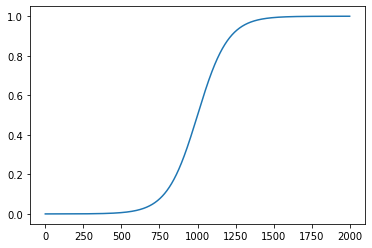

In [3]:
def log_function(x):
    return 1/(1+np.exp(-x))

x = [log_function(x) for x in np.arange(-10,10,0.01)]

plt.plot(x);

## Simple binning

The `SimpleBucketer` object creates binning of the values of `x` into equally sized bins. The attributes `counts`, the number of elements per bin, and `boundaries`, the actual boundaries that resulted from the binning strategy, are assigned to the object instance. In this example we choose to get 4 bins:

In [4]:
mySimpleBucketer = SimpleBucketer(bin_count=4)
mySimpleBucketer.fit(x)
print('counts', mySimpleBucketer.counts_)
print('boundaries', mySimpleBucketer.boundaries_)

counts [891 109 110 890]
boundaries [4.53978687e-05 2.50022585e-01 4.99999772e-01 7.49976959e-01
 9.99954146e-01]


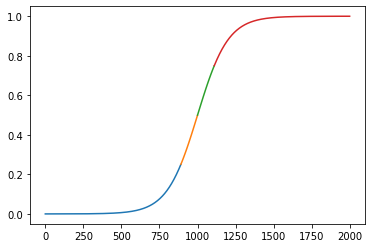

In [5]:
df = pd.DataFrame({'x':x})
df['label'] = pd.cut(x, bins=mySimpleBucketer.boundaries_, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].plot(ax=ax, y='x', legend=False)

As can be seen, the number of elements in the tails of the data is larger than in the middle:

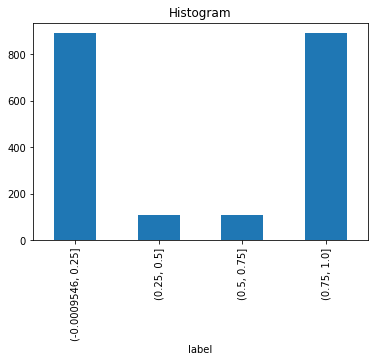

In [6]:
df.groupby('label')['x'].count().plot(kind='bar');
plt.title('Histogram');

## Quantile binning 

The `QuantileBucketer` object creates bins that all contain an equal amount of samples

In [7]:
myQuantileBucketer = QuantileBucketer(bin_count=4)
myQuantileBucketer.fit(x)
print('counts', myQuantileBucketer.counts_)
print('boundaries', myQuantileBucketer.boundaries_)

counts [500 500 500 500]
boundaries [4.53978687e-05 6.67631251e-03 4.98750010e-01 9.93257042e-01
 9.99954146e-01]


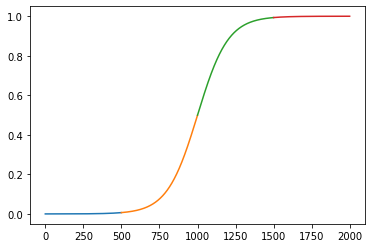

In [8]:
df = pd.DataFrame({'x':x})
df['label'] = pd.cut(x, bins=myQuantileBucketer.boundaries_, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].plot(ax=ax, y='x', legend=False)

As can be seen, the number of elements is the same in all bins:

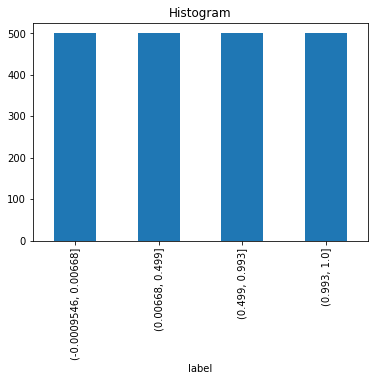

In [9]:
df.groupby('label')['x'].count().plot(kind='bar');
plt.title('Histogram');

## Binning by agglomerative clustering

The `AgglomerativeBucketer` class applies the Scikit-Learn `AgglomerativeClustering` algorithm to the data and uses the clusters to determine the bins.
We use different data to show the value of this algoritm; we create the following distribution:

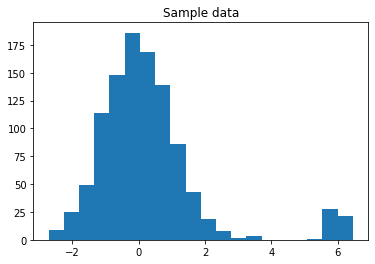

In [10]:
x_agglomerative = np.append(np.random.normal(0,1,size=1000), np.random.normal(6,0.2,size=50))
plt.hist(x_agglomerative, bins=20);
plt.title('Sample data');

When we apply the `AgglomerativeBucketer` algorithm with 2 bins, we see that the algorithm nicely creates a split in between the two centers

In [11]:
myAgglomerativeBucketer = AgglomerativeBucketer(bin_count=2)
myAgglomerativeBucketer.fit(x_agglomerative)
print('counts', myAgglomerativeBucketer.counts_)
print('boundaries', myAgglomerativeBucketer.boundaries_)

counts [1000   50]
boundaries [-2.71525699097944, 4.582406874429196, 6.454492599188006]


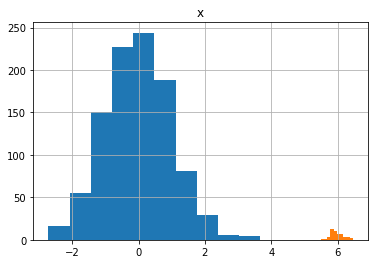

In [12]:
df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=myAgglomerativeBucketer.boundaries_, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

Note that the `SimpleBucketer` strategy would just have created a split in the middle of the maximum and the minimum (at about 1.75). The `QuantileBucketer` strategy had created two bins with equal amount of elements in it, resulting in a split at around 0.

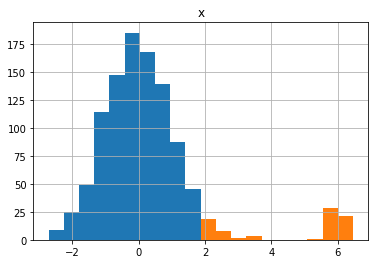

In [13]:
counts_agglomerative_simple, boundaries_agglomerative_simple = SimpleBucketer.simple_bins(x_agglomerative, 2)

df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=boundaries_agglomerative_simple, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

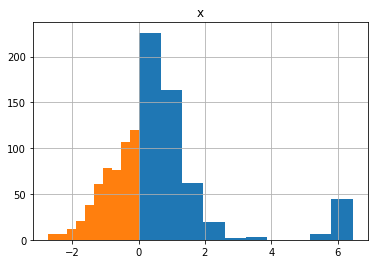

In [14]:
counts_agglomerative_quantile, boundaries_agglomerative_quantile = QuantileBucketer.quantile_bins(x_agglomerative, 2)

df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=boundaries_agglomerative_quantile, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

# Binning with Decision Trees

Binning with decision trees leverages the information of a binary feature or the binary target in order to create buckets that have a significantly different proportion of the binary feature/target. <br>

It works by fitting a tree on 1 feature only. <br>
It leverages the properties of the split finder algorithm in the decision tree. The splits are done to maximize the gini/entropy. <br> 
The leaves approximate the optimal bins.

The example below shows a distribution defined by a step function

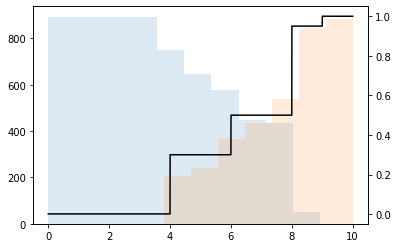

In [15]:
def make_step_function(x):
    if x<4:
        return 0.001
    elif x<6:
        return 0.3
    elif x<8:
        return 0.5
    elif x<9:
        return 0.95
    else: return 0.9999
    

x = np.arange(0,10,0.001)
probs = [make_step_function(x_) for x_ in x]

y = np.array([1 if np.random.rand()<prob else 0 for prob in probs])

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.hist(x[y==0], alpha=0.15)
ax.hist(x[y==1], alpha=0.15)
ax2.plot(x,probs, color='black')
plt.show()

The light blue histogram indicates the distribution of class 0 (`y=0`), while the light orange histogram indicates the distribution of class 1 (`y=1`). <br>
The black line indicates the probability function that isused to assign class 0 or 1. In this toy example, it's a step function.

100%|██████████| 5/5 [00:00<00:00, 17985.87it/s]


counts by TreeBucketer: [4000 1998 2001  936 1065]
counts by QuantileBucketer: [625 625 625 625 625 625 625 625 625 625 625 625 625 625 625 625]


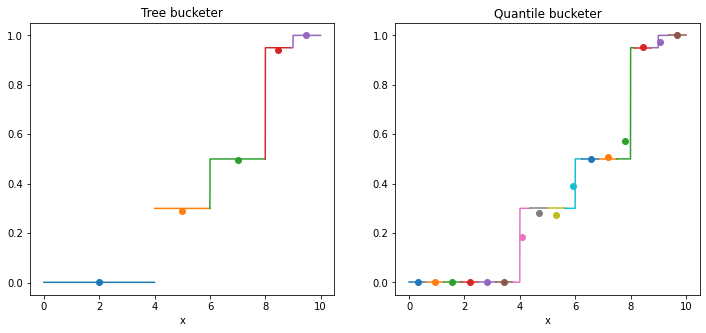

In [16]:
# Try a tree bucketer
tb = TreeBucketer(
    inf_edges=True, 
    max_depth=4,
   criterion = 'entropy',
   min_samples_leaf =400 , #Minimum number of entries in the bins
   min_impurity_decrease=0.001
).fit(x,y)

counts_tree, boundaries_tree = tb.counts_, tb.boundaries_

df_tree = pd.DataFrame({
    'x':x, 
    'y':y,
    'probs':probs
})

df_tree['label'] = pd.cut(x, bins=boundaries_tree, include_lowest=True)

# Try a quantile bucketer
myQuantileBucketer = QuantileBucketer(bin_count=16)
myQuantileBucketer.fit(x)
q_boundaries =  myQuantileBucketer.boundaries_
q_counts =  myQuantileBucketer.counts_

df_q = pd.DataFrame({
    'x':x, 
    'y':y,
    'probs':probs
})
df_q['label'] = pd.cut(x, bins=q_boundaries, include_lowest=True)


fig, ax = plt.subplots(1,2, figsize = (12,5))

for label in df_tree.label.unique():
    df_tree[df_tree.label==label].plot(ax=ax[0], x = 'x', y='probs', legend=False)
    ax[0].scatter( df_tree[df_tree.label==label]['x'].mean(), df_tree[df_tree.label==label]['y'].mean())
    ax[0].set_title("Tree bucketer")
    
for label in df_q.label.unique():
    df_q[df_q.label==label].plot(ax=ax[1], x = 'x', y='probs', legend=False)
    ax[1].scatter(df_q[df_q.label==label]['x'].mean(), df_q[df_q.label==label]['y'].mean())
    ax[1].set_title("Quantile bucketer")
    
print(f"counts by TreeBucketer: {counts_tree}")
print(f"counts by QuantileBucketer: {q_counts}")

Comparing the `TreeBucketer` and the `QuantileBucketer` (the dots compare the average distribution of class 1 in the bin): <br>
Each buckets obtained by the `TreeBucketer` follow the probability distribution (i.e. the entries in the bucket have the same probability of being class 1). <br>
On the contrary, the `QuantileBucketer` splits the values below 4 in 6 buckets, which all have the same probability of being class 1.<br>
Note also that the tree is grown with the maximum depth of 4, which potentially lets it grow up to 16 buckets ($2^4$).<br>

The learned tree is visualized below, whreere the splitting according to the step function is visualized clearly.



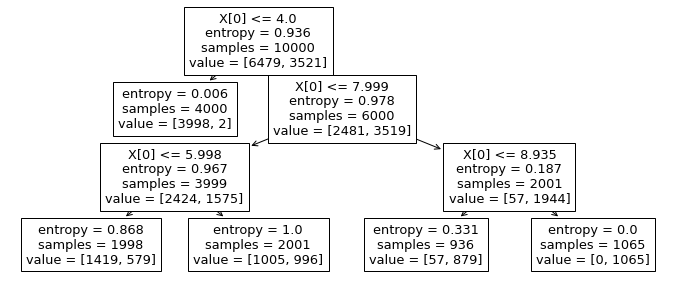

In [17]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize = (12,5))
tre_out = plot_tree(tb.tree, ax = ax)